<a href="https://colab.research.google.com/github/miguelangelbg/weather_prediction/blob/main/weather_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training temperature prediction model

**Author: Miguel Ángel Ballester Granell**

Code inspired by Tensorflow tutorial https://www.tensorflow.org/tutorials/structured_data/time_series

This notebook contains the necessary code for training and evaluating the recurrent neural network for temperature forecast.

## Libraries

In [1]:
import os
import importlib

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    import sys
    project_path = 'drive/MyDrive/Colab Notebooks/weather_forecasting/'
    sys.path.append(project_path)
else:
    project_path = ''

import weather_forecast
importlib.reload(weather_forecast)

Mounted at /content/drive


<module 'weather_forecast' from 'drive/MyDrive/Colab Notebooks/weather_forecasting/weather_forecast.py'>

## Data loading

In [2]:
# Load data
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)

# Split
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train = df[0:int(n*0.7)]
val = df[int(n*0.7):int(n*0.9)]
test = df[int(n*0.9):]

## Preprocessing pipeline

In [3]:
preprocess_pl = weather_forecast.WeatherPreprocessing()

train_df = preprocess_pl.fit_transform(data=train)

val_df = preprocess_pl.transform(data=val)

test_df = preprocess_pl.transform(data=test)

num_features = train_df.shape[1]

preprocess_pl.save_params(project_path + 'model/preprocess_params.csv')

In [4]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945312,-1.982498,-2.041914,-1.918985,1.117072,-1.302871,-1.477334,-0.790414,-1.480047,-1.482708,2.218550,0.193410,0.221176,0.111140,0.217940,0.366097,1.366039,-0.061035,1.428453
11,0.959775,-2.078398,-2.138193,-2.060975,1.044588,-1.330162,-1.534364,-0.786262,-1.536200,-1.539045,2.325735,0.172987,0.222115,0.109458,0.227811,0.707187,1.224765,-0.060012,1.428442
17,0.986289,-2.070310,-2.132462,-2.045198,1.062709,-1.328863,-1.527235,-0.788338,-1.528713,-1.532003,2.324026,0.207983,0.276281,0.111217,0.324092,1.000088,1.000031,-0.058989,1.428431
23,1.004367,-2.098040,-2.161116,-2.096831,1.008346,-1.336660,-1.546245,-0.782111,-1.547431,-1.553129,2.358940,0.270344,0.195281,0.246908,0.145188,1.224839,0.707151,-0.057966,1.428419
29,1.061012,-2.165054,-2.232179,-2.187188,0.984185,-1.353555,-1.579513,-0.782111,-1.581122,-1.585992,2.446348,0.112264,0.350833,0.048639,0.402067,1.366124,0.366086,-0.056943,1.428407


## Window generator

Total window size: 64
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Label column name(s): ['T (degC)']

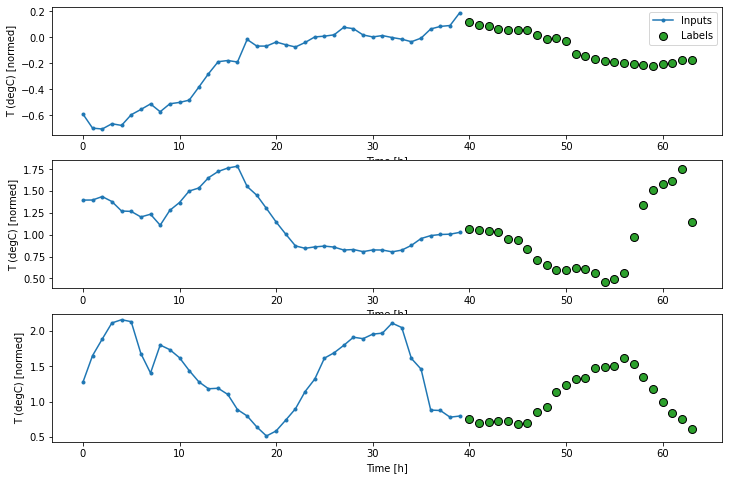

In [5]:
OUT_STEPS = 24
multi_window = weather_forecast.WindowGenerator(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    input_width=40,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=['T (degC)']
)

multi_window.plot()
multi_window

## Define model

In [6]:
model = weather_forecast.WeatherModel(input_shape=(multi_window.input_width, len(multi_window.column_indices)), out_steps=OUT_STEPS)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 19)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 12)                1536      
_________________________________________________________________
dense (Dense)                (None, 24)                312       
_________________________________________________________________
reshape (Reshape)            (None, 24, 1)             0         
Total params: 1,848
Trainable params: 1,848
Non-trainable params: 0
_________________________________________________________________


## Training

In [7]:
model.compile_and_fit(multi_window, patience=4, max_epochs=30)

Epoch 1/30
1532/1532 [==============================] - 28s 17ms/step - loss: 0.3268 - mean_absolute_error: 0.4110 - val_loss: 0.0926 - val_mean_absolute_error: 0.2338
Epoch 2/30
1532/1532 [==============================] - 25s 17ms/step - loss: 0.0840 - mean_absolute_error: 0.2230 - val_loss: 0.0850 - val_mean_absolute_error: 0.2221
Epoch 3/30
1532/1532 [==============================] - 25s 17ms/step - loss: 0.0768 - mean_absolute_error: 0.2117 - val_loss: 0.0808 - val_mean_absolute_error: 0.2147
Epoch 4/30
1532/1532 [==============================] - 26s 17ms/step - loss: 0.0728 - mean_absolute_error: 0.2046 - val_loss: 0.0798 - val_mean_absolute_error: 0.2126
Epoch 5/30
1532/1532 [==============================] - 28s 18ms/step - loss: 0.0706 - mean_absolute_error: 0.2005 - val_loss: 0.0782 - val_mean_absolute_error: 0.2097
Epoch 6/30
1532/1532 [==============================] - 26s 17ms/step - loss: 0.0691 - mean_absolute_error: 0.1980 - val_loss: 0.0781 - val_mean_absolute_error:

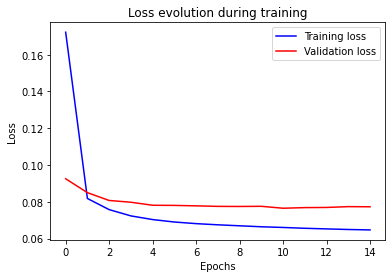

In [8]:
model.visualize_loss()

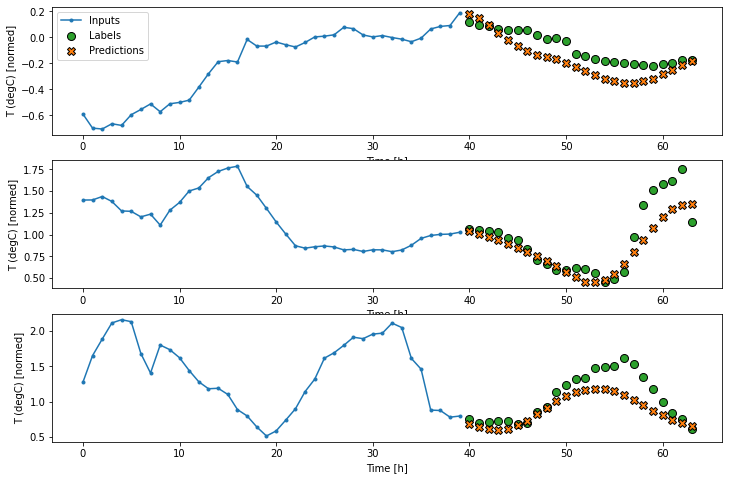

In [9]:
multi_window.plot(model)

## Error analysis

In [10]:
def visualize_model_error(true, pred, dataset):

    errors = y_true - y_pred

    print('Model results (' + dataset + ')')
    mean_sqr_error = np.mean(errors**2)

    print('Mean squared error: ' + str(round(mean_sqr_error, 4)))
    ss_res = np.sum(errors**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res/ss_tot

    print('R2: ' + str(round(r2, 4)))

    fig, axs = plt.subplots(1,1, figsize=(15,5))

    sns.violinplot(data=[errors[:,i,0] for i in range(errors.shape[1])], ax=axs)

    axs.set_title('Error distribution for each predicted timestep - ' + dataset)
    axs.set_xlabel('Timestep')

    plt.show()

### Training data

Model results (Training)
Mean squared error: 0.065
R2: 0.9349


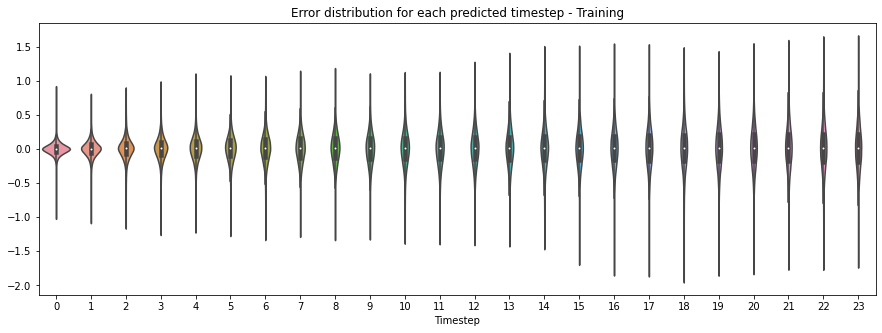

In [11]:
y_true = np.concatenate([y for x, y in multi_window.train_no_shuffle], axis=0)
y_pred = model.predict(multi_window.train_no_shuffle)

visualize_model_error(y_true, y_pred, 'Training')

### Validation data

Model results (Validation)
Mean squared error: 0.0773
R2: 0.901


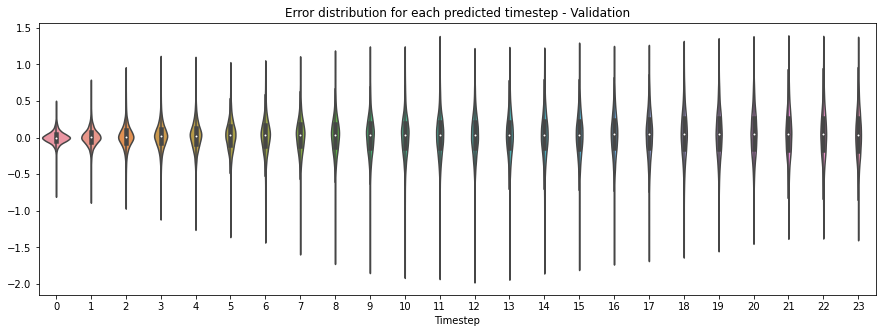

In [12]:
y_true = np.concatenate([y for x, y in multi_window.val], axis=0)
y_pred = model.predict(multi_window.val)

visualize_model_error(y_true, y_pred, 'Validation')

### Test data

Model results (Test)
Mean squared error: 0.0624
R2: 0.9233


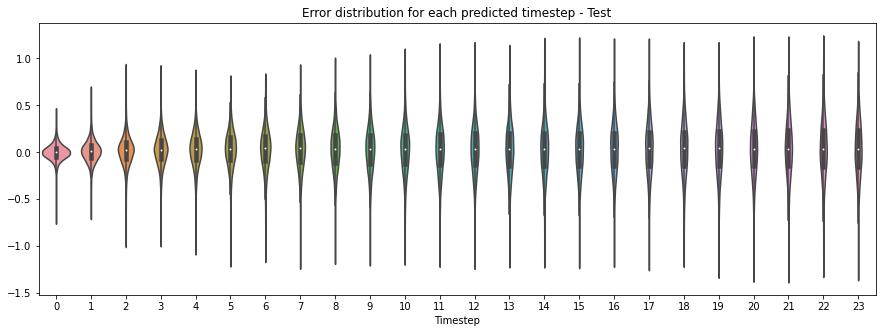

In [13]:
y_true = np.concatenate([y for x, y in multi_window.test], axis=0)
y_pred = model.predict(multi_window.test)

visualize_model_error(y_true, y_pred, 'Test')

## Save model

In [14]:
model.save_weights(filepath=project_path + 'model/weather_model.h5')

# model.load_weights(patproject_path + 'model/weather_model.h5'5')